# Player Projections Notebook

This Jupyter notebook is used for generating player projections in fantasy sports. It uses various Python libraries to scrape data, perform calculations, and visualize results.

## Section 1: Importing Libraries

The first section of the notebook is dedicated to importing the necessary Python libraries that will be used throughout the notebook:

- `datetime`, `json`, `shutil`, `time`, and `pathlib.Path` are standard Python libraries used for handling date and time, JSON data, file operations, and file paths respectively.

- `gspread` is used for interacting with Google Spreadsheets.

- `matplotlib.pyplot` is used for creating plots and visualizations.

- `numpy` and `pandas` are used for numerical computations and data manipulation.

- `scipy.stats` is used for statistical computations.

- `selenium` and its related imports are used for web scraping.

In [1]:
import datetime
import json
import shutil
import time
from pathlib import Path

import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait

## Section 2: Data Preparation

In this section, we will set CONSTANTS for desired column_order to be used later, as well as the number of players we want, URLs for All and Even strength stats, and the URL for our Fantrax league.


In [2]:
COLUMN_ORDER = [
    "Player",
    "Team",
    "Position",
    "GP",
    "D Points",
    "Goals",
    "Total Assists",
    "Shots",
    "Special Teams Points",
    "Hits",
    "Shots Blocked",
    "Takeaways",
    "Faceoffs Won",
    "TOI",
]

NUM_PLAYERS = 300
URL_ALL_STRENGTHS, URL_EVEN_STRENGTH = (
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=ev&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
)
URL_FBL_FANTRAX = "https://www.fantrax.com/fantasy/league/1papyorqllbhqzl7/players;statusOrTeamFilter=ALL;pageNumber=1"



## Section 3: Data Preparation

In this section, we will perform data preparation tasks such as loading data, cleaning data, and adding additional columns. 

Let's start by loading the data from the CSV files. The `load_data()` function is used to load the data from the specified file path. If the file exists and was modified within the last hour, it will load the data from the CSV file. Otherwise, it will scrape the data from the website and save it to the CSV file before loading it.

Next, we will clean the data by adding a unique identifier for each player and performing any necessary data cleaning operations.

Finally, we will add additional columns to the dataframe, such as "D Points" and "Special Teams Points", which will be used for further analysis.

Let's execute the code block below to perform these data preparation tasks:

In [3]:
# Load data
def load_data(file_path):
    # File path.. Path...
    file = Path(file_path)
    # 1 hour = 3600 seconds
    hour = 3600
    # Check if the file exists
    if file.exists():
        # Get the modification time of the CSV
        modtime = file.stat().st_mtime
        # Get the current time
        current_time = time.time()
        # If the file is less than an hour old, load it else scrape the data
        dataframe = pd.read_csv(file_path, index_col=0) if current_time - modtime < hour else scrape_data(file_path)
    # If the file doesn't exist, scrape the data
    else:
        dataframe = scrape_data(file_path)

    return dataframe


In [4]:
# Scrape data
def scrape_data(file_path):
    # Set the URL based on the file path
    if file_path == "all_strengths.csv":
        url = URL_ALL_STRENGTHS
    elif file_path == "even_strength.csv":
        url = URL_EVEN_STRENGTH
    # Scrape the data
    dataframe = pd.read_html(url, index_col=0)[0] 
    # Save to csv
    dataframe.to_csv(file_path)

    return dataframe

In [5]:
def setup_driver():
    options = Options()
    options.set_preference("browser.download.folderList", 2) # custom location
    options.set_preference("browser.download.manager.showWhenStarting", False)
    options.set_preference("browser.download.dir", str(Path.cwd()))
    options.set_preference("browser.helperApps.neverAsk.saveToDisk", "text/csv")
    return webdriver.Firefox(options=options)

In [6]:
def login(driver, wait):
    driver.get("https://www.fantrax.com/login")
    email = wait.until(ec.presence_of_element_located((By.CSS_SELECTOR, 'input[formcontrolname="email"]')))
    password = wait.until(ec.presence_of_element_located((By.CSS_SELECTOR, 'input[formcontrolname="password"]')))
    with Path("credentials.json").open() as f:
        credentials = json.load(f)
    email.send_keys(credentials["username"])
    password.send_keys(credentials["password"])
    login_button = wait.until(ec.element_to_be_clickable((By.CSS_SELECTOR, 'button[type="submit"]')))
    login_button.click()

In [7]:
def download_data(driver, wait, file_path):
    today = datetime.datetime.now(tz=datetime.UTC).strftime("%Y-%m-%d")

    url = f"https://www.fantrax.com/fxpa/downloadPlayerStats?leagueId=1papyorqllbhqzl7&pageNumber=1&view=STATS&positionOrGroup=HOCKEY_SKATING&seasonOrProjection=SEASON_31h_YEAR_TO_DATE&timeframeTypeCode=YEAR_TO_DATE&transactionPeriod=15&miscDisplayType=1&sortType=SCORE&maxResultsPerPage=20&statusOrTeamFilter=ALL&scoringCategoryType=5&timeStartType=PERIOD_ONLY&schedulePageAdj=0&searchName=&datePlaying=ALL&startDate=2023-10-10&endDate={today}&teamId=0ph241vmllbhqzlf&"
    # Wait for the element with the class "text--ellipsis" to be present
    wait.until(ec.presence_of_element_located((By.CSS_SELECTOR, "h5.text--ellipsis")))
    driver.get(url)
    default_filename = "Fantrax-Players-Fantasy Beard League.csv"
    shutil.move(default_filename, file_path)

In [8]:
# This will be used to scrape data from Fantrax
def scrape_fantrax(file_path):
    file = Path(file_path)
    # Check if the file exists and was modified today
    if file.exists():
        # Get the modification time of the CSV
        modtime = datetime.datetime.fromtimestamp(file.stat().st_mtime, tz=datetime.UTC)
        # Check if it was modified today
        if modtime.date() == datetime.datetime.now(tz=datetime.UTC).date():
            return pd.read_csv(file_path, index_col=0, nrows=1000)

    # Set up the driver and set the wait time
    driver = setup_driver()
    wait = WebDriverWait(driver, 10)
    # Login to Fantrax
    login(driver, wait)
    # Download the data
    download_data(driver, wait, file_path)
    # Read the CSV into a dataframe
    data = pd.read_csv(file_path, nrows=1000)

    driver.quit()

    return data


In [9]:
# Add D and STP column
def add_d_and_stp(df_all, df_even):
    # Add D and STP columns
    df_all["D Points"] = np.where(df_all["Position"] == "D", df_all["Total Points"], 0)
    df_all["Special Teams Points"] = df_all["Total Points"] - df_even["Total Points"]

    return df_all


In [10]:
# Add things for cleaning data if needed
def clean_data(dataframe):
    # Create a unique ID for each player to avoid issues with same name players
    dataframe["UID"] = dataframe.groupby("Player").cumcount()

    return dataframe


In [11]:
# Analyze data
def analyze_data(dataframe):
    # Make a copy of the dataframe to avoid modifying the original data
    dataframe = dataframe.copy()

    # Start index at 1 for better readability (Python usually starts indexing at 0)
    dataframe.index = dataframe.index + 1

    # List of categories to analyze
    categories = [
        "D Points",
        "Goals",
        "Total Assists",
        "Shots",
        "Special Teams Points",
        "Hits",
        "Shots Blocked",
        "Takeaways",
        "Faceoffs Won",
        "TOI",
    ]

    # Calculate z-scores for overall season statistics
    # Z-scores standardize data to have mean of 0 and standard deviation of 1
    for category in categories:
        dataframe[category] = pd.to_numeric(dataframe[category], errors="coerce")
    filtered_data = dataframe[categories].apply(zscore)
    dataframe["Season Value"] = filtered_data.sum(axis=1)
    season_rankings = dataframe.sort_values("Season Value", ascending=False)

    # Normalize stats by games played
    # This gives per game statistics instead of total season statistics
    for category in categories:
        dataframe[category] = dataframe[category] / dataframe["GP"]

    # Calculate z-scores for per game statistics
    filtered_data = dataframe[categories].apply(zscore)
    dataframe["Per Game Value"] = filtered_data.sum(axis=1)
    per_game_rankings = dataframe.sort_values("Per Game Value", ascending=False)

    # Select and order columns
    # This makes the data easier to read and understand
    season_rankings = season_rankings.loc[:, ["Season Value", *COLUMN_ORDER]]
    per_game_rankings = per_game_rankings.loc[:, ["Per Game Value", *COLUMN_ORDER]]

    # Add 'Rank' Column
    # This gives a ranking to each player based on their season or per game value
    season_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))
    per_game_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))

    # Return the rankings for both season and per game statistics
    return season_rankings, per_game_rankings


In [12]:
def find_value(season_rankings, per_game_rankings):
    gp_min = 5
    # Ensure Player and UID is set as index for both dataframes
    season_rankings = season_rankings.set_index("Player")
    per_game_rankings = per_game_rankings.set_index("Player")
    # Filter out players who have played 5 games or less
    season_rankings = season_rankings[season_rankings["GP"] > gp_min]
    per_game_rankings = per_game_rankings[per_game_rankings["GP"] > gp_min]
    # Calculate discrepancy in value
    discrepancy = (per_game_rankings["Per Game Value"] - season_rankings["Season Value"])
    # Create a new DataFrame for discrepancy
    discrepancy_df = discrepancy.to_frame(name="Discrepancy")
    # Filter players where Per Game Value is higher than Season Value
    filtered_discrepancy = discrepancy_df[discrepancy_df["Discrepancy"] > 0]
    # sort player by discrepancy
    sorted_discrepancy = filtered_discrepancy.sort_values("Discrepancy", ascending=False)
    # Select and return the top 50 players
    return sorted_discrepancy.head(50)


In [13]:
# Format and print dataframe
def format_and_print(dataframe):
    # Nested function to color rows
    # This function is used to apply a style to the DataFrame
    def color_rows(s):
        # Use a list comprehension to create a list of styles
        # If the row index is even, the background color will be #44475a
        # If the row index is odd, the background color will be #282a36
        return ["background-color: #44475a" if i % 2 else "background-color: #282a36" for i in range(len(s))]

    # Apply the color_rows function to the DataFrame
    # This will color the rows according to the rules defined in color_rows
    # The hide method is used to hide the index of the DataFrame
    return dataframe.style.apply(color_rows).hide_index()

In [14]:
# Visualize rankings
def visualize_top_50_discrepancy(season_rankings, per_game_rankings):
    # Get top 50 players by discrepancy
    # The find_value function is expected to return a DataFrame of the top 50 players by discrepancy
    top_50_players = find_value(season_rankings, per_game_rankings)

    # Sort players by discrepancy in ascending order
    # This makes it easier to see which players have the largest discrepancy
    top_50_players = top_50_players.sort_values(by="Discrepancy", ascending=True)

    # Create horizontal bar plot
    # The figure size is set to 10x10 for better visibility
    plt.figure(figsize=(10, 10))
    # The y-values are the player names (index of top_50_players)
    # The x-values are the discrepancy values
    bars = plt.barh(top_50_players.index, top_50_players["Discrepancy"])

    # Add discrepancy values at the end of each bar
    # This makes it easier to see the exact discrepancy value for each player
    for bar in bars:
        xval = bar.get_width()
        # The text is positioned at the end of the bar, in the middle vertically
        plt.text(xval, bar.get_y() + bar.get_height() / 2, round(xval, 2), va="center")

    # Set the title of the plot and the labels of the x and y axes
    plt.title("Top 50 Players by Discrepancy")
    plt.xlabel("Discrepancy")
    plt.ylabel("Player")

    # Display the plot
    plt.show()


In [15]:
# Output to Google Sheets
def output_to_gsheets(dataframe, worksheet_name, column_order):
    gc = gspread.oauth()
    sh = gc.open("FantasyStats")

    # Get the worksheet or create it if it doesn't exist
    try:
        worksheet = sh.worksheet(worksheet_name)
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=worksheet_name, rows="400", cols="25")

    # Clear the worksheet
    worksheet.clear()
    # Convert the index to a column
    dataframe = dataframe.reset_index(level=0)

    # Reorder the columns
    dataframe = dataframe.reindex(columns=column_order)

    # Calculate the range
    num_rows = len(dataframe.index) + 1  # +1 to account for the header row
    num_cols = len(dataframe.columns)
    # Convert column number to letter
    col_letter = chr(64 + num_cols)
    range_name = f"A1:{col_letter}{num_rows}"

    # Update the worksheet with the DataFrame data
    worksheet.update(values = [dataframe.columns.to_numpy().tolist(),
                             *dataframe.to_numpy().tolist()], range_name=range_name)


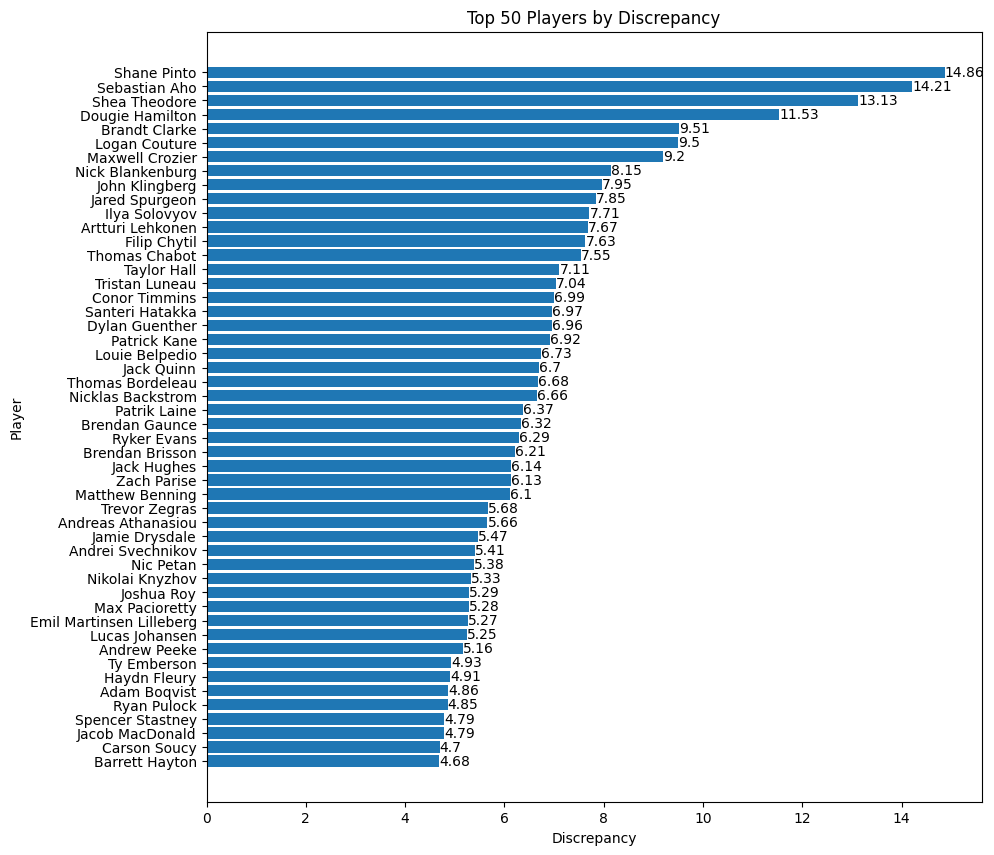

C:\Users\holym\AppData\Local\Temp\ipykernel_16708\2484663146.py:28: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values = [dataframe.columns.to_numpy().tolist(),
C:\Users\holym\AppData\Local\Temp\ipykernel_16708\2484663146.py:28: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values = [dataframe.columns.to_numpy().tolist(),


In [16]:
# Main function
def main():
    all_strengths = load_data("all_strengths.csv")
    even_strength = load_data("even_strength.csv")
    all_stats_df = add_d_and_stp(all_strengths, even_strength)
    fantrax_data = scrape_fantrax("fantrax_data.csv")  # noqa: F841
    season_rankings, per_game_rankings = analyze_data(all_stats_df)
    visualize_top_50_discrepancy(season_rankings, per_game_rankings)
    output_to_gsheets(season_rankings, "Season Rankings", ["Rank", "Season Value", *COLUMN_ORDER])
    output_to_gsheets(per_game_rankings, "Per Game Rankings", ["Rank", "Per Game Value", *COLUMN_ORDER])


# Run the main function
if __name__ == "__main__":
    main()
